# Project 3 -  Sweet Spot Swindle

Jasmine Kamdar and Colin Takeda- Team 3


In the game of billiards, the player seeks to have the greatest control over the cue ball and the target ball. In order to achieve the greatest amount of control one is often advised to hit the ball in the coveted 'sweet spot.' The 'sweet spot' has come to mean the height at which one applied a force where the cue ball immediately starts rolling without slipping. However, does the 'sweet spot' actually affect one's ability to play the game? 

## Question

Does hitting the sweet spot in pool have a significant effect on the end result of a pool shot, if initial velocity is held constant? For this model, a significant effect will be quantified by the time taken to get to rolling without slipping and the difference in end velocity. 

In [37]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr'

# import functions from the modsim.py module
from modsim import *

In [38]:
#adding units
m = UNITS.meter
s = UNITS.second
degree = UNITS.degree
radian = UNITS.radian
newton = UNITS.newton
kg = UNITS.kilogram

## Modeling Choices and Assumptions

We started by completing online research on the basic measurements we would need for completing this model. Specifically we got data for initial velocity, coefficients of friction and rolling resistance, mass and radius of the ball, dimensions of the pool table and amount of time the cue is in contact with the ball. We used the work of Dr. Dave Alciatore of Colorado State University to find these parameters. We made the assumptions that the force is applied parallel to the ground and applied to a singular point. We also assumed there was no drag. These assumptions do not have a significant effect on our model because we were comparing heights and as long as all of the heights received the same forces the resulting sweet spot would not have changed. Additionally, air resistance does not have a major effect during this simulation. 

In [39]:
params = Params( #Coefficients / relavent metrics are by Dr. Dave Alciatore of Colorado State University
        
               v_0 = 1.9 * m/s, 
                    #initial velocity of an average shot
               cof_f= 0.2,     
                    #Coefficient of friction between the ball and table
               cof_res=0.015,   
                    #Coefficient of rolling resistance between the ball and table       
               r_ball = 0.05715/2 * m, 
                    #radius of ball
               m_ball = 0.17 * kg, 
                    #mass of ball
               g = 9.8 *m / s**2, 
                    #acceleration due to gravity
               L = 2.4384 * m, 
                    #farthest linear length on a pool table
               t_end = 50 * s, 
                    #max time
               t_cue = 0.002 *s, 
                    #amount of time cue is touching 
               h = 0
                    #height above radius shot is hit
              )
print(params)

v_0             1.9 meter / second
cof_f                          0.2
cof_res                      0.015
r_ball              0.028575 meter
m_ball               0.17 kilogram
g          9.8 meter / second ** 2
L                     2.4384 meter
t_end                    50 second
t_cue                 0.002 second
h                                0
dtype: object


## Differential Equations

Our next step was to get the ball rolling. In order to this, we researched relevant literature on rolling with and without slipping. Moment of inertia is an important aspect in knowing the ball’s resistance to angular acceleration. We used the equation for a solid spherical body to find the ball’s moment of inertia. There are two forces of friction that we accounted for. The force of friction is used for when the ball is starting to roll as it is creating the torque for the ball. The force of rolling resistance is when the ball is rolling without slipping which causes the ball to slow down. There is a rolling resistance because although the ball is a rigid object, the table is a deformable surface, causing there to be a force slowing the ball down. We set the initial force to 50 Newtons because online research showed this value to be in the range of average pool shots. We also researched the equation for the initial angular velocity from the force exerted by the cue. The angular velocity would be varied depending on the height above the center of mass at which the force from the cue is applied. This height changes the torque and thus changes the initial angular velocity. We were able to find the equation for the time the ball will start rolling wihtout slipping using the equation v=ωr. 

In [40]:
def make_system(params):
    
    unpack(params)
    
    I = (2/5)*m_ball * r_ball**2 
        #moment of inertia of solid spherical ball
    F_f = cof_f*m_ball*g 
        #force of friction between the ball and table
    F_res = cof_res*m_ball*g 
        #force of rolling resistance between ball and table
          
    #F_init = m_ball*v_0/t_cue #Not sure if correct
    F_init = 20 * kg*m/s**2 
        #force applied by cue
         
    #w_0 = F_init*(h*m)/I*t_cue *radian
    w_0 = (h*v_0*(5/2))/r_ball**2 *radian*m
        #initial angular velocity as soon as cue applies force

    t_roll = abs((2/(7*cof_f*g))*(v_0-(r_ball*w_0)))

    #setting state variables
    init = State(x=0, theta=0, 
                 vx=v_0, omega=w_0) 
    
   
    return System(init=init,t_end=t_end,I=I,F_f=F_f,F_res=F_res,F_init=F_init,w_0=w_0,t_roll=t_roll)
  

In [41]:
system = make_system(params)
print(system)

init      x                          0
theta            ...
t_end                                             50 second
I                      5.55240825e-05 kilogram * meter ** 2
F_f       0.33320000000000005 kilogram * meter / second ...
F_res     0.024990000000000005 kilogram * meter / second...
F_init                  20.0 kilogram * meter / second ** 2
w_0                                     0.0 radian / second
t_roll                            0.2769679300291545 second
dtype: object


## Slope Function

In the slope function, we created an if else statement that seperated how the velocity, angular velocity, angular acceleration, and acceleration was calculated depending on if the ball was slipping or rolling without slipping. When there is rolling without slipping, the point touching the ball is not moving for the instant it is touching the ground. Therefore, there is no kinetic friction. However, when there is slipping, there is a velocity on that point and thus friction must be taken into account. 

In [42]:
def slope_func(state, t, system):
    
    x, theta, v, omega = state
    unpack(system)
    t=t*s
    x=x*m
    
    if t < t_roll: #Overspin - Slipping occurs
    
        #Linear Equations
        a = -(F_f+F_res)/m_ball
        v = sqrt((v_0**2)+(2*cof_f*g*x))
        
        #Rotation Equations
        omega = ((5*cof_f*g)/(2*r_ball))*t*radian
        alpha = (5*cof_f*g)/(2*r_ball) *radian
        
    else: #Rolling without Slipping 
        
        #Linear equations
        a = -F_res/m_ball #No friction when rolling without slipping
        v = v_0 + a*t
        
        #Rotation Equations
        omega = v/r_ball *radian
        alpha = a/r_ball *radian
        

    return v, omega, a, alpha

In [43]:
slope_func(system.init, 0, system)

(<Quantity(1.9, 'meter / second')>,
 <Quantity(0.0, 'radian / second')>,
 <Quantity(-2.107, 'meter / second ** 2')>,
 <Quantity(171.4785651793526, 'radian / second ** 2')>)

## Event Function

The event function was created to stop the simulation when the ball hits the end of the table. We used the value of L, which is the greatest linear distance on a pool table at Olin.

In [44]:
def event_func(state,t,system):
    
    unpack(system)
    x, theta, v, omega = state
  
    return L - x #stops the ball when it hits the end of the table

In [45]:
event_func(init,0,system)

<Quantity(2.4384, 'meter')>

## Results

**Control Results: **We then used an ode solver to calculate the differential equations to give us the ball's velocity, accleration, angular velocity, and angular acceleration at each time step. For these plots, we  tested a height of 0 meters from the center of mass. We plotted the position, velocity, angular velocity and angular position over time. 


In [46]:
results, details = run_ode_solver(system,slope_func,events=event_func, max_step=0.05)


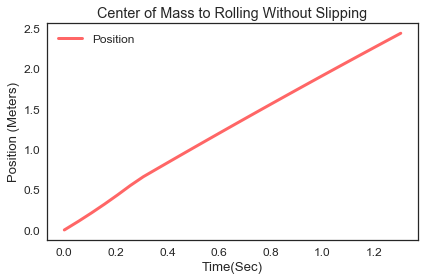

In [47]:
plot(results.x,'r',label='Position') 
    #plots position
#plot(results.vx,label='Velocity')
    #plots velocity 
#plot(results.omega,label='Omega')
    #plots angular velocity
#plot(results.theta,label='Theta')
    #plots angular position
decorate(title=
         'Center of Mass to Rolling Without Slipping',
         xlabel='Time(Sec)',
         ylabel='Position (Meters)')

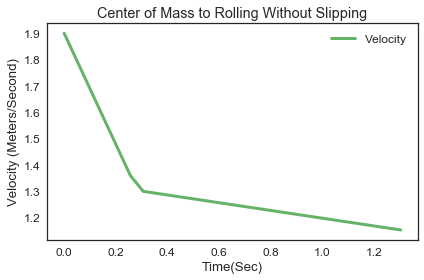

In [48]:
plot(results.vx,'g',label='Velocity')
    #plots velocity 
decorate(title=
         'Center of Mass to Rolling Without Slipping',
         xlabel='Time(Sec)',
         ylabel='Velocity (Meters/Second)')

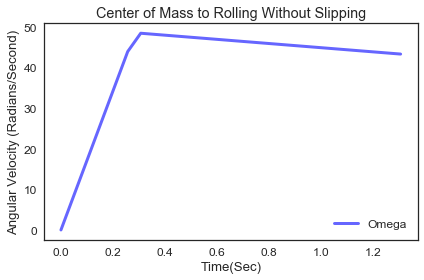

In [49]:
plot(results.omega,'b',label='Omega')
    #plots angular velocity
decorate(title=
         'Center of Mass to Rolling Without Slipping',
         xlabel='Time(Sec)',
         ylabel='Angular Velocity (Radians/Second)')

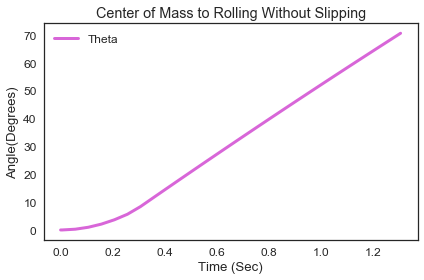

In [50]:
plot(results.theta,'m',label='Theta')
    #plots angular position
decorate(title=
         'Center of Mass to Rolling Without Slipping',
         xlabel='Time (Sec)',
         ylabel='Angle(Degrees)')

We can see from the angular velocity plot that the angular velocity is initially 0, and the angular velocity increases due to torque caused by friction. We can also see that the angular velocity then decreases once there is rolling without slipping. We also see that position and angular position both increases over time. Finally, we can see that velocity is decreasing over time. 

**Sweet Spot Results:** To compare the results recieved from the center of mass simulation to the actual sweet spot simulation, we repeated our method. We plotted the position, velocity, angular velocity and angular position. 

In [51]:
params = Params(params,h=.01143)
system = make_system(params)
results, details = run_ode_solver(system,slope_func,events=event_func, max_step=0.05)

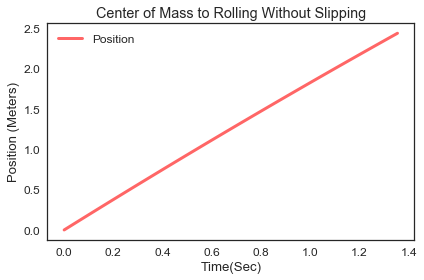

In [52]:
plot(results.x,'r',label='Position') 
    #plots position
decorate(title=
         'Center of Mass to Rolling Without Slipping',
         xlabel='Time(Sec)',
         ylabel='Position (Meters)')

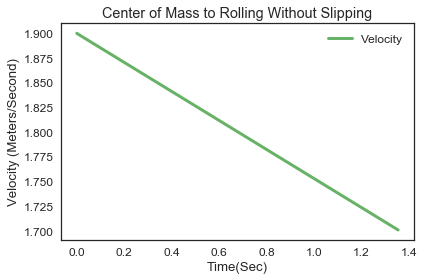

In [53]:
plot(results.vx,'g',label='Velocity')
    #plots velocity 
decorate(title=
         'Center of Mass to Rolling Without Slipping',
         xlabel='Time(Sec)',
         ylabel='Velocity (Meters/Second)')

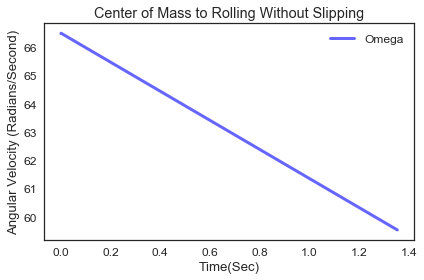

In [54]:
plot(results.omega,'b',label='Omega')
    #plots angular velocity
decorate(title=
         'Center of Mass to Rolling Without Slipping',
         xlabel='Time(Sec)',
         ylabel='Angular Velocity (Radians/Second)')

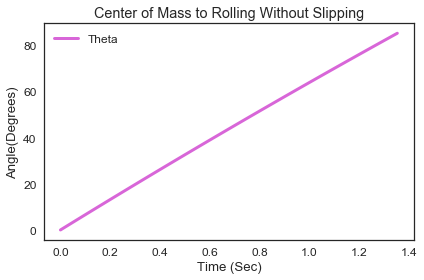

In [55]:
plot(results.theta,'m',label='Theta')
    #plots angular position
decorate(title=
         'Center of Mass to Rolling Without Slipping',
         xlabel='Time (Sec)',
         ylabel='Angle(Degrees)')

The results show instantaneous rolling without slipping because there is no slop changes in any of the graphs. There is the same pattern of positions and angular positions increasing with time, and velocity decreasing with time. However, there is a major difference with angular velocity slopes because from the start the angular velocity is decreasing, since it starts with rolling without slipping. 

**Sweet Spot Calculation Results:** We created a function to compare a variety of different heights above the center of mass where the cue would hit the ball. We plotted a graph with height on the x-axis and the time the ball starts rolling without slipping on the y-axis. This plot results in an absolute value function showing the time the ball starts rolling without slipping depending on height from the center of mass.


In [56]:
sh= (np.linspace(0,.028,100))
#Heights above the center of mass to the outer radius of the cue ball

In [57]:
sweep = SweepSeries()

In [58]:
for x in range(len(sh)):
    params = Params(params,h=sh[x])
    system = make_system(params)
  
    #print(system.t_roll)
    sweep[sh[x]] = system.t_roll

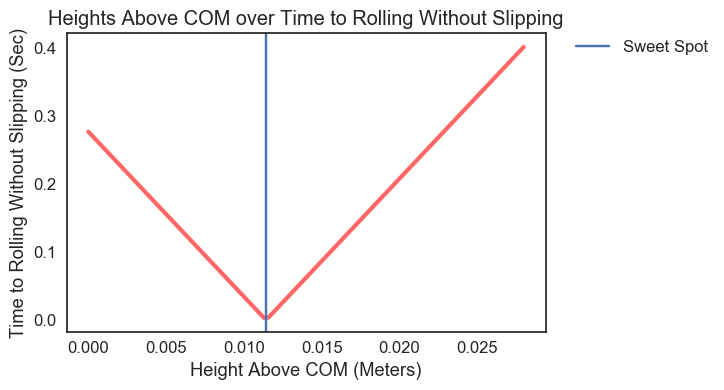

In [59]:
plt.figure(dpi = 100)
plot(sweep,'r')
plt.axvline(x=.01143,label='Sweet Spot') 
decorate(title="Heights Above COM over Time to Rolling Without Slipping",
            ylabel='Time to Rolling Without Slipping (Sec)',
            xlabel='Height Above COM (Meters)')

legend(bbox_to_anchor=(1.05,1), loc='upper left', borderaxespad=0.)

The results show us the point where there is the least amount of time until rolling without slipping, thus the sweet spot. The blue line makes it easy to see that the actual, researched sweet spot and the relative minimum is about .011m.

**Sweep Results:** We created a sweep function that would sweep different heights above the center of mass. Then we plotted each of these heights' change in velocities over time.  

In [60]:
sh= (np.linspace(0,.028,5))
sh= np.sort(np.insert(sh,0,.01143))
print(sh)
 #Heights above the center of mass to the outer radius of the cue ball
sweep2=SweepSeries()

[0.      0.007   0.01143 0.014   0.021   0.028  ]


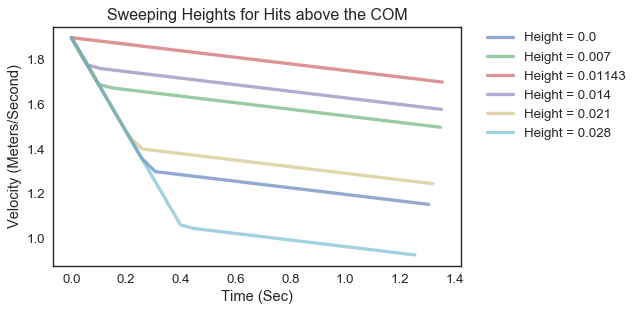

In [61]:
plt.figure(dpi = 80)
for x in range(len(sh)):
    params = Params(params,h=sh[x])
    system = make_system(params)

    results, details = run_ode_solver(system,slope_func,events=event_func, max_step=0.05)
    plot(results.vx,label=("Height = " + str(sh[x])))
    
    decorate(title="Sweeping Heights for Hits above the COM",
            xlabel='Time (Sec)',
            ylabel='Velocity (Meters/Second)')
    sweep2[sh[x]] = get_last_value(results.vx)
    legend(bbox_to_anchor=(1.05,1), loc='upper left', borderaxespad=0.)

This sweep shows us the height of .01143 has the greatest velocity throughout the simulation and no change in slope because of immediate rolling without slipping. Additionally, we can see where all of the points on the ball compare with the sweet spot in terms of final velocity and time it takes to rolling without slipping. 

**Final Velocity Results:** We also plotted a graph that compared the final velocities with the different heights in order to examine the significance of the effects of hitting the sweet spot. 

0.00000    1.152563
0.00700    1.498217
0.01143    1.700782
0.01400    1.578296
0.02100    1.244938
0.02800    0.926000
dtype: float64


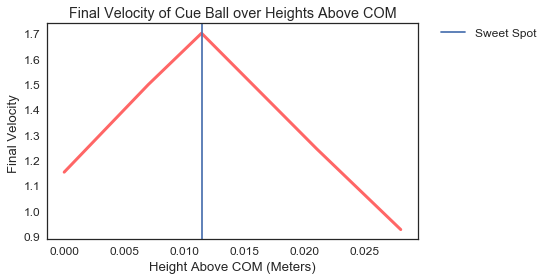

In [62]:
plot(sweep2,'r')
print(sweep2)
decorate(title="Final Velocity of Cue Ball over Heights Above COM",
            ylabel='Final Velocity ',
            xlabel='Height Above COM (Meters)')
plt.axvline(x=.01143,label='Sweet Spot') 


legend(bbox_to_anchor=(1.05,1), loc='upper left', borderaxespad=0.)

Again we can see the sweet spot having the greatest final velocity and as you hit farther from the sweet spot the final velocities decrease. 

## Interpretation

- Hitting the ball in the center of mass means that there is no initial torque supplied by the cue and the only torque to create the angular velocity is the friction. Therefore, the ball will take significantly longer to achieve rolling without slipping.
- The results displaying a parabolic curve shows us decreasing values in times it takes to start rolling without slipping as the height gets close to the value of approximately .011 m. The time it takes to start rolling without slipping at the height of .011 m is nearly 0 s, meaning it is our defined sweet spot. 
- Hitting the sweet spot does have a major effect on the end velocity because the end velocity of the sweet spot is 1.700782 m/s, while the end velocity of hitting the center of mass is 1.152563 m/s and hitting the top of the ball is .926000 m/s. 
- The sweet spot is shown to be significant in the control in the game of pool because there is nearly immediate rolling without slipping. 

## Validation

We found from multiple online sources that the ideal sweet spot in pool is ⅖ of the radius. If we take ⅖ of our parameter value for radius (.028575m), we will get .01143. This expected value parallels our findings and the final graphs for the sweep of different heights above the center of mass. 